In [19]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import os
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.simplefilter('ignore')
np.random.seed(42)

In [9]:
mnist = pd.read_csv('../data/mnist-demo.csv')
mnist.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
X = mnist.iloc[:,1:].values
y = mnist.iloc[:,0].values

## Train test split

In [20]:
shuffle_index = np.random.permutation(len(X))
X = X[shuffle_index]
y = y[shuffle_index]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2)

In [22]:
y_train_5 = y_train == 5
y_test_5 = y_test == 5

In [23]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(max_iter=10, random_state=42,)
sgd.fit(X_train,y_train_5)
sgd.predict([X[3500]])


SGDClassifier(max_iter=10, random_state=42)

## Cross Validation

### Use package

In [52]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd, X_train, y_train_5, cv = 5, scoring='accuracy') # cross_val_score will directly return the score you specified

array([0.971875, 0.969375, 0.964375, 0.9575  , 0.963125])

### Write explicitly

In [34]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone ## clone the original estimator/model. Make sure that each fold use the model with same parameter
kf = StratifiedKFold(n_splits=3).split(X_train, y_train_5)
for train_index, test_index in kf:
    model = clone(sgd)
    X_train_fold = X_train[train_index]
    X_test_fold = X_train[test_index]
    y_train_fold = y_train_5[train_index]
    y_test_fold = y_train_5[test_index]
    model.fit(X_train_fold, y_train_fold)
    y_pred = model.predict(X_test_fold)
    y_correct = sum(y_pred == y_test_fold)
    print(y_correct/len(y_test_fold))

0.9647544056992876
0.9535058117735283
0.9666166541635409


## Confusion matrix

In [37]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
y_pred_cv = cross_val_predict(sgd,X_train,y_train_5,cv=5) # cross_val_predict will provide you the predicted results based on the method you specified
confusion_matrix(y_train_5,y_pred_cv) # rows being the actual labels and columns being pred labels

array([[7215,  107],
       [ 171,  507]])

### Precision
$$
     \frac{TP}{TP+FP}
$$

In [42]:
507/(507+107)

0.8257328990228013

In [41]:
from sklearn.metrics import precision_score
precision_score(y_train_5,y_pred_cv)

0.8257328990228013

### Recall
$$
    \frac{TP}{TP+FN}
$$

In [43]:
507/(507+171)

0.7477876106194691

In [44]:
from sklearn.metrics import recall_score
recall_score(y_train_5,y_pred_cv)

0.7477876106194691

### F1 Score
- This is the harmonic mean of precision and recall. It will slightly bias toward the smaller value of the two.
$$
    \frac{1}{\frac{1}{Recall}+\frac{1}{Precision}}
$$

In [48]:
from sklearn.metrics import f1_score
f1_score(y_train_5,y_pred_cv)

0.7848297213622292

### Precision/Recall Tradeoff

In [64]:
y_scores = cross_val_predict(sgd,X_train, y_train_5, cv = 3, method = 'decision_function') ## creating prediction scores of each obs
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores) ## generate various thresholds and corresponding precisions and recalls

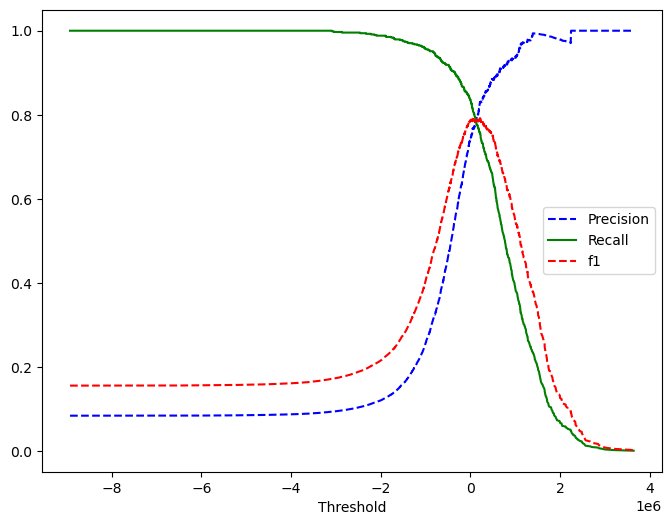

In [67]:
def precision_recall_curve(precisions, recalls, thresholds):
    plt.plot(thresholds,
             precisions[:-1],
             'b--',
             label = 'Precision')
    
    plt.plot(thresholds,
             recalls[:-1],
             'g-',
             label = 'Recall')
    
    f1 = 2/(1/precisions + 1/recalls)
    plt.plot(thresholds,
             f1[:-1],
             'r--',
             label = 'f1')
    plt.xlabel('Threshold', fontsize = 10)
    plt.legend(fontsize = 10)
    
plt.figure(figsize = (8,6))
precision_recall_curve(precisions, recalls, thresholds)
plt.show()

### ROC Curve

- ROC curve is not used to choose the best threshold for a given model
- It is mostly used to compare and determine a best model from many
- X axis represents the false positive rate (FPR), which equals FP/(FP+TN)
- Y axis represents the true positive rate (TPR), which is the recall rate, and equals to TP/(TP+FN)
- the left bottom corner, essentially means you predict everything to be negative. 
- the right top corner, essentially means you predict everything to be positive.
- the larger of the area under the ROC curve, the better of the model is
- the diagonal line is corresponding to a model with random guess
- with a better model, the TPR will not drop that much while FPR drops

In [74]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores) # similar to prediction_recall_curve, each point represents a threshold, and the corresponding fpr and tpr

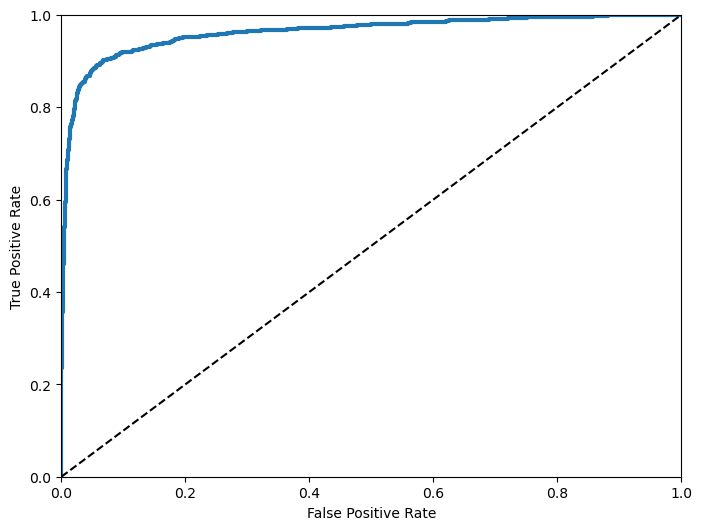

In [72]:
def roc_curve_plot(fpr, tpr, label = None):
    plt.plot(fpr, tpr, linewidth = 3, label = label)
    plt.plot([0,1], [0,1], 'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate', fontsize = 10)
    plt.ylabel('True Positive Rate', fontsize = 10)

plt.figure(figsize = (8,6))
roc_curve_plot(fpr, tpr)
plt.show()

In [75]:
roc_auc_score(y_train_5, y_scores)

0.9622421296307488